In [1]:
!git clone https://github.com/facebookresearch/detectron2.git
%cd detectron2
!pip install -e .
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
#print(detectron2.__version__)


Cloning into 'detectron2'...
remote: Enumerating objects: 15554, done.
remote: Counting objects: 100% (279/279), done.
remote: Compressing objects: 100% (215/215), done.
remote: Total 15554 (delta 95), reused 206 (delta 64), pack-reused 15275
Receiving objects: 100% (15554/15554), 6.41 MiB | 21.12 MiB/s, done.
Resolving deltas: 100% (11210/11210), done.
/kaggle/working/detectron2
Obtaining file:///kaggle/working/detectron2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 691.7 kB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 1.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

<_Logger detectron2 (DEBUG)>

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2.data.datasets import register_coco_instances
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import pickle
# import some common libraries
import numpy as np
import random
import os, json, cv2, random
import matplotlib.pyplot as plt
import skimage.io as io
import seaborn as sns
# For visualization
import os
import seaborn as sns
from matplotlib import colors
from tensorboard.backend.event_processing import event_accumulator as ea
from PIL import Image

# Scipy for calculating distance
from scipy.spatial import distance
# Set base params
plt.rcParams["figure.figsize"] = [16,9]

In [3]:
config_file_path="COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
checkpoint_url="COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"

In [4]:
output_dir="./output/object_detection"
#num_classes=21
device="cuda"

In [5]:
register_coco_instances(name="my_dataset_train",metadata = {}, json_file="/kaggle/input/car-parts-polygon/coco_annotations.json",image_root= "/kaggle/input/car-parts-polygon/Carpartsandcardamagesdataset/Car damages dataset/File1/img")
#register_coco_instances(name="my_dataset_val", metadata = {}, json_file="/kaggle/input/car-parts-detection/valid/_annotations.coco.json",image_root="/kaggle/input/car-parts-detection/valid")
#register_coco_instances(name="my_dataset_test",metadata = {}, json_file="/kaggle/input/car-parts-detection/test/_annotations.coco.json",image_root= "/kaggle/input/car-parts-detection/test")


In [6]:
def plot_samples(dataset_name,n=1):
    dataset_dicts = DatasetCatalog.get(dataset_name)
    metadata_dicts = MetadataCatalog.get(dataset_name)
    
    for s in random.sample(dataset_dicts,n):
        img=cv2.imread(s["file_name"])
        v=Visualizer(img[:,:,::-1],metadata=metadata_dicts,scale=0.5)
        v=v.draw_dataset_dict(s)
        plt.figure(figsize=(15,20))
        plt.imshow(v.get_image())
        plt.show

[04/28 23:14:20 d2.data.datasets.coco]: Loading /kaggle/input/car-parts-polygon/coco_annotations.json takes 1.00 seconds.
WARNING [04/28 23:14:20 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/28 23:14:20 d2.data.datasets.coco]: Loaded 998 images in COCO format from /kaggle/input/car-parts-polygon/coco_annotations.json
WARNING [04/28 23:14:20 d2.data.datasets.coco]: Filtered out 8149 instances without valid segmentation. There might be issues in your dataset generation process.  Please check https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html carefully


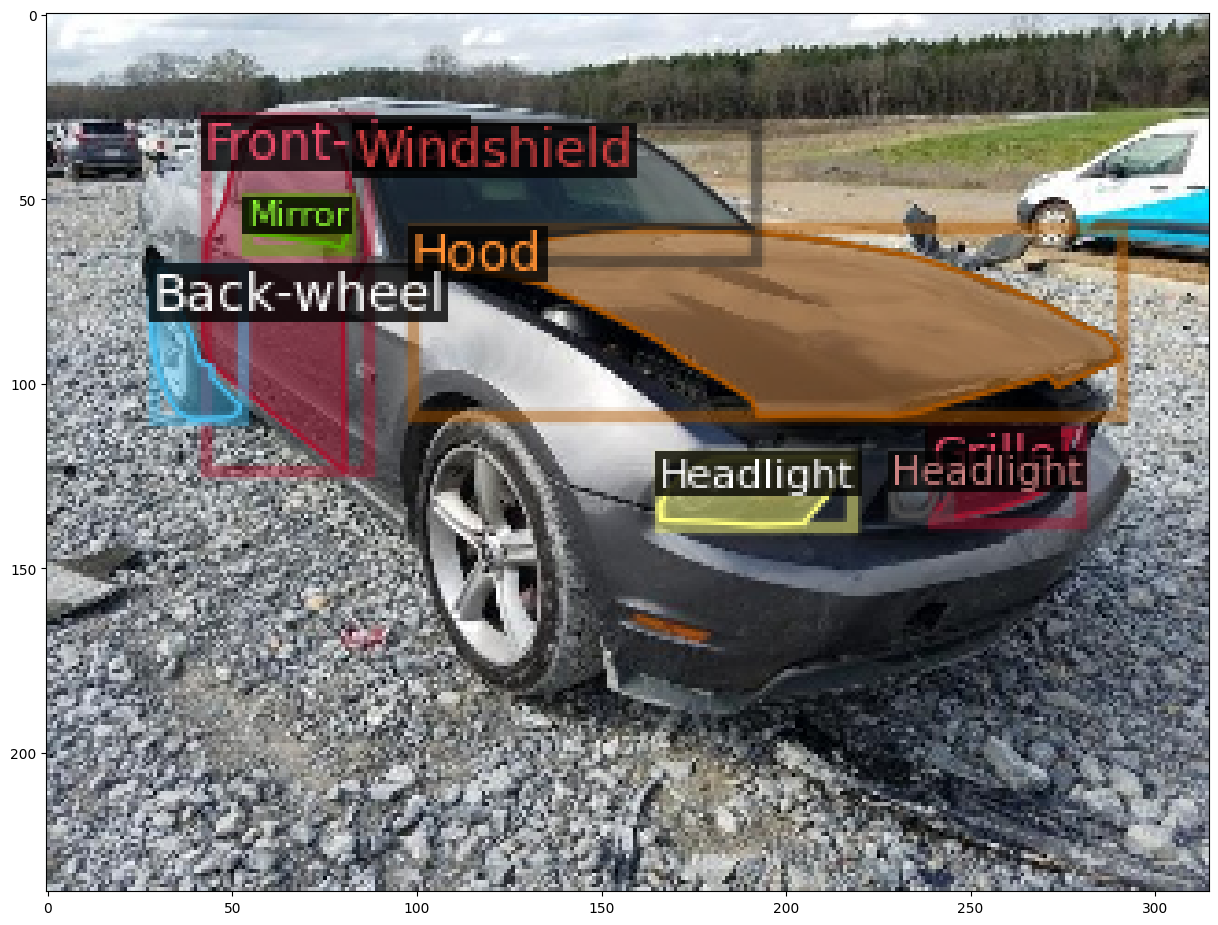

In [7]:
plot_samples("my_dataset_train",n=1)
#plot_samples("my_dataset_val",n=1)
#plot_samples("my_dataset_test",n=1)

In [8]:
from detectron2.data import MetadataCatalog

# Get metadata for the training and validation datasets
train_metadata = MetadataCatalog.get("my_dataset_train")
#val_metadata = MetadataCatalog.get("my_dataset_val1")
#test_metadata= MetadataCatalog.get("my_dataset_test")

# Print metadata for the training dataset
print("Metadata for training dataset:")
print(train_metadata)

# Print metadata for the validation dataset
print("Metadata for validation dataset:")
print(test_metadata)


Metadata for training dataset:
Metadata(name='my_dataset_train', json_file='/kaggle/input/car-parts-polygon/coco_annotations.json', image_root='/kaggle/input/car-parts-polygon/Carpartsandcardamagesdataset/Car damages dataset/File1/img', evaluator_type='coco', thing_classes=['Quarter-panel', 'Front-wheel', 'Back-window', 'Trunk', 'Front-door', 'Rocker-panel', 'Grille', 'Windshield', 'Front-window', 'Back-door', 'Headlight', 'Back-wheel', 'Back-windshield', 'Hood', 'Fender', 'Tail-light', 'License-plate', 'Front-bumper', 'Back-bumper', 'Mirror', 'Roof'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20})
Metadata for validation dataset:


NameError: name 'test_metadata' is not defined

In [9]:
cfg_save_path="OD_cfg.pickle"

In [10]:
#Implementing my own Trainer Module here to use the COCO validation evaluation during training
# TODO: add data custom augmentation
class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [11]:
device="cuda"

In [12]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml") 
cfg.DATASETS.TRAIN = ("my_dataset_train",)
#cfg.DATASETS.TEST = ("my_dataset_test",)
cfg.DATALOADER.NUM_WORKERS = 4
 # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
#cfg.SOLVER.WARMUP_ITERS = 10000
cfg.SOLVER.MAX_ITER = 25000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = []
cfg.SOLVER.GAMMA = 0.05
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 24  # only has one class (damage) + 1
cfg.MODEL.DEVICE=device
#cfg.TEST.EVAL_PERIOD = 5000


# Clear any logs from previous runs
#TODO add timestamp to logs
!rm -rf cfg.OUTPUT_DIR

with open(cfg_save_path,'wb') as f:
    pickle.dump(cfg,f,protocol=pickle.HIGHEST_PROTOCOL)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[04/28 23:14:52 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 165MB/s]                             


[04/28 23:14:55 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/28 23:15:18 d2.utils.events]:  eta: 6:22:52  iter: 19  total_loss: 5.17  loss_cls: 3.077  loss_box_reg: 0.6666  loss_mask: 0.6937  loss_rpn_cls: 0.6284  loss_rpn_loc: 0.09766    time: 0.9195  last_time: 1.0025  data_time: 0.0218  last_data_time: 0.0118   lr: 1.9981e-05  max_mem: 4792M


2024-04-28 23:15:21.892122: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 23:15:21.892239: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 23:15:22.145177: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[04/28 23:15:52 d2.utils.events]:  eta: 6:21:19  iter: 39  total_loss: 4.901  loss_cls: 2.645  loss_box_reg: 0.7117  loss_mask: 0.6927  loss_rpn_cls: 0.5676  loss_rpn_loc: 0.118    time: 0.9311  last_time: 1.0205  data_time: 0.0114  last_data_time: 0.0115   lr: 3.9961e-05  max_mem: 4900M
[04/28 23:16:11 d2.utils.events]:  eta: 6:29:54  iter: 59  total_loss: 3.58  loss_cls: 1.777  loss_box_reg: 0.8266  loss_mask: 0.6906  loss_rpn_cls: 0.2217  loss_rpn_loc: 0.1113    time: 0.9438  last_time: 1.0118  data_time: 0.0114  last_data_time: 0.0112   lr: 5.9941e-05  max_mem: 4900M
[04/28 23:16:32 d2.utils.events]:  eta: 6:47:33  iter: 79  total_loss: 3.156  loss_cls: 1.367  loss_box_reg: 0.8493  loss_mask: 0.6891  loss_rpn_cls: 0.149  loss_rpn_loc: 0.08998    time: 0.9660  last_time: 1.0859  data_time: 0.0119  last_data_time: 0.0117   lr: 7.9921e-05  max_mem: 4902M
[04/28 23:16:53 d2.utils.events]:  eta: 6:51:53  iter: 99  total_loss: 3.045  loss_cls: 1.288  loss_box_reg: 0.881  loss_mask: 0.685

KeyboardInterrupt: 

In [16]:
with open(cfg_save_path,'rb') as f:
    cfg=pickle.load(f)

In [14]:
def smooth(scalars, weight=0.6):
    """
    Reference: https://github.com/plotly/dash-live-model-training/blob/master/app.py#L163
    """
    last = scalars[0]
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed


def plot1(logdir: str, savedir: str, smoothing: float = 0.6, no_title=False, no_legend=False, no_axis_labels=False):
    """ re-draw the tf summary events plots  using seaborn
    :param logdir: Path to the directory having event logs
    :param savedir: Path to save the seaborn graphs
    :param smoothing: smoothing window space for the plots
    """
    assert 0 <= smoothing <= 1, 'Smoothing value should be in [0,1]'

    plots = []

    sns.set(style="darkgrid")
    sns.set_context("paper")

    # Collect data
    # we recognize all files which have tfevents
    scalars_info = {}
    for root, dirs, files in os.walk(logdir):
        for event_file in [x for x in files if 'tfevents' in x]:
            event_path = os.path.join(root, event_file)

            acc = ea.EventAccumulator(event_path)
            acc.Reload()

            # only support scalar now
            scalar_list = acc.Tags()['scalars']
            for tag in scalar_list:
                x = [s.step for s in acc.Scalars(tag)]
                y = [s.value for s in acc.Scalars(tag)]
                data = {'x': x, 'y': y, 'legend': root.split(logdir)[1][1:] if root != logdir else None}
                if tag not in scalars_info:
                    scalars_info[tag] = [data]
                else:
                    scalars_info[tag].append(data)

    # We recognize groups assuming each group name has /
    # And, each group is saved in a separate directory
    for tag, tag_data in scalars_info.items():
        _split = tag.split('/')
        if len(_split) <= 1:
            _path = os.path.join(savedir, 'seaborn')
            _name = _split[0]
        else:
            _path = os.path.join(savedir, 'seaborn', _split[0])
            _name = ''.join(_split[1:])

        os.makedirs(_path, exist_ok=True)

        color_list = list(sns.color_palette(palette='dark', n_colors=len(tag_data)))[::-1]
        for data in tag_data:
            x, y = data['x'], data['y']
            y_smooth = smooth(y, weight=smoothing)
            current_color = color_list.pop()
            _plt = sns.lineplot(x=x, y=y, color=colors.to_rgba(current_color, alpha=0.4))
            _legend = data['legend'] if not no_legend else None
            _plt = sns.lineplot(x=x, y=y_smooth, label=data['legend'], color=current_color)

        if not no_axis_labels:
            _plt.set(xlabel='x', ylabel='y')
        if not no_title:
            _plt.set_title(_name.capitalize())

        plots.append(os.path.join(_path, _name + '.png'))
        plt.savefig(os.path.join(_path, _name + '.png'))
        plt.clf()
    return plots

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

KeyError: 'y'

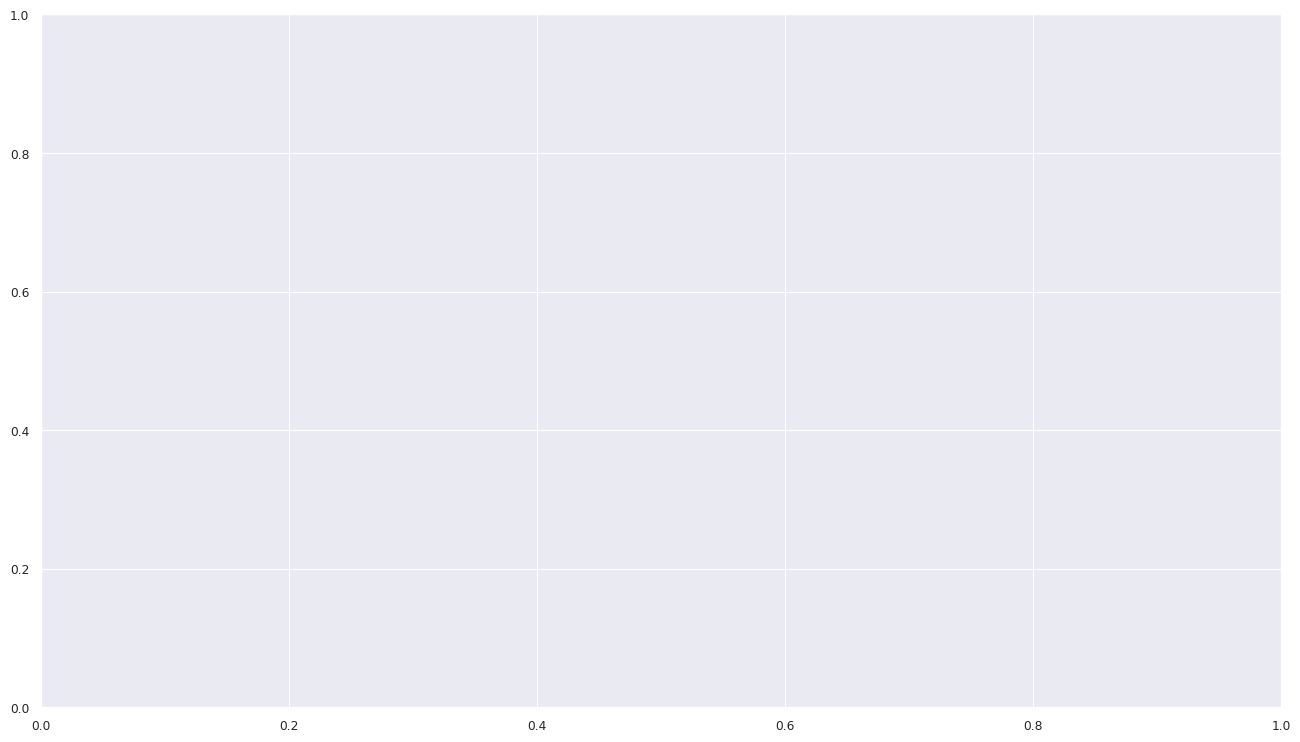

In [15]:
plots = plot1(logdir= './output', savedir= './')

In [16]:
my_dpi = 1000
fig, ax = plt.subplots(4,1, figsize = (12,10), dpi=my_dpi)


ax[0].set_title('Total Loss', fontsize=12)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].imshow(Image.open('./seaborn/total_loss.png'))

ax[1].set_title('Bounding Box Average Precision', fontsize=12)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].imshow(Image.open('./seaborn/bbox/AP.png'))

ax[2].set_title('Segmentation Average Precision', fontsize=12)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].imshow(Image.open('./seaborn/segm/AP.png'))

ax[3].set_title('Class accuracy', fontsize=12)
ax[3].set_xticks([])
ax[3].set_yticks([])
ax[3].imshow(Image.open('./seaborn/fast_rcnn/cls_accuracy.png'))

FileNotFoundError: [Errno 2] No such file or directory: './seaborn/segm/AP.png'

In [17]:
# List of class names
class_names = ['Quarter-panel', 'Front-wheel', 'Back-window', 'Trunk', 'Front-door', 'Rocker-panel', 'Grille', 'Windshield', 'Front-window', 'Back-door', 'Headlight', 'Back-wheel', 'Back-windshield', 'Hood', 'Fender', 'Tail-light', 'License-plate', 'Front-bumper', 'Back-bumper', 'Mirror', 'Roof']

# Create a dictionary with numbers associated with class names
class_label_dict = {i: class_name for i, class_name in enumerate(class_names)}

print(class_label_dict)


{0: 'Quarter-panel', 1: 'Front-wheel', 2: 'Back-window', 3: 'Trunk', 4: 'Front-door', 5: 'Rocker-panel', 6: 'Grille', 7: 'Windshield', 8: 'Front-window', 9: 'Back-door', 10: 'Headlight', 11: 'Back-wheel', 12: 'Back-windshield', 13: 'Hood', 14: 'Fender', 15: 'Tail-light', 16: 'License-plate', 17: 'Front-bumper', 18: 'Back-bumper', 19: 'Mirror', 20: 'Roof'}


In [1]:
car_parts_dict={0: 'Quarter-panel', 1: 'Front-wheel', 2: 'Back-window', 3: 'Trunk', 4: 'Front-door', 5: 'Rocker-panel', 6: 'Grille', 7: 'Windshield', 8: 'Front-window', 9: 'Back-door', 10: 'Headlight', 11: 'Back-wheel', 12: 'Back-windshield', 13: 'Hood', 14: 'Fender', 15: 'Tail-light', 16: 'License-plate', 17: 'Front-bumper', 18: 'Back-bumper', 19: 'Mirror', 20: 'Roof'}
def on_image(image_path,predictor):
        img=cv2.imread(image_path)
        outputs=predictor(img)
        pred_classes = outputs["instances"].get("pred_classes").cpu().numpy()
        for pred_class in pred_classes:
            car_parts = car_parts_dict.get(pred_class, "Unknown")
            print("Predicted Damage Type:", car_parts)
        v=Visualizer(img[:,:,::-1],metadata={},scale=0.5,instance_mode=ColorMode.SEGMENTATION)
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        plt.figure(figsize=(14,10))
        plt.imshow(v.get_image())
        plt.show()
    

In [2]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3   # set a custom testing threshold

predictor = DefaultPredictor(cfg)
image_path="/kaggle/input/test-dataset/8.jpg"

on_image(image_path,predictor)

NameError: name 'os' is not defined

In [ ]:
from IPython.display import FileLink
import os
FileLink(os.path.join(cfg.OUTPUT_DIR, "model_final.pth"))
